### Main goals:
✅ Clarify and reflect on the definition of the term "fake news", which may vary among databases, sometimes non-binary.\
✅ Research, where the data comes from and inspect the data: what are the labels, sources, and authors?\
✅ Is there a person, source or topic which is over- or under-represented?\
✅ Study the literature on how others approach this task. Check the related literature and select your model architecture of choice: LSTM, ...\
✅ Develop a classification model to predict fake news from the text. How do you judge the quality of your results, i.e. which metrics do you consider?
### Optional:
Inspect the falsely classified ones. What can you learn from them?\
Investigate edge cases that you found in your data inspection with respect to how the model learned to identify these.\
Experiment with how you could mitigate if edge cases are covered poorly.

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments,Trainer, pipeline
from datasets import load_dataset
import numpy as np
import evaluate
from sklearn.metrics import classification_report
from bertviz import model_view,head_view
import shap
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from bertopic import BERTopic

## Model Training

#### Downloading the base model and getting the tokenizer
The code below is not necessary to run, as we fine-tuned the model and uploaded it to HuggingFace, therefore just go down to the Model inspection part.

In [2]:
# model_name = "google-bert/bert-base-uncased"

In [3]:
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [4]:
# tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True)

#### Loading the data set

In [6]:
# data = load_dataset('GonzaloA/fake_news')

In [7]:
# data = data.remove_columns(['Unnamed: 0','title'])

In [8]:
# tokenized_data = data.map(tokenize_function, batched=True)

#### Sampling from the data set

In [9]:
# small_train_dataset = tokenized_data["train"].shuffle(seed=42).select(range(100))
# small_eval_dataset = tokenized_data["validation"].shuffle(seed=42).select(range(100))
# small_test_dataset = tokenized_data['test']

#### Outputting the training arguments

In [10]:
# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

#### Loading the evaluation metrics

In [11]:
# metric = evaluate.load("accuracy")

In [12]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

#### Initializing the Trainer object and fine-tuning the model

In [13]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [14]:
# trainer.train()

#### Getting the predictions

In [15]:
# test_labels = small_test_dataset['label']
# small_test_dataset = small_test_dataset.remove_columns(['label','token_type_ids'])

In [16]:
# predictions = trainer.predict(small_test_dataset)

In [17]:
# predicted_labels = predictions.predictions.argmax(axis=1)

#### Saving the model

In [18]:
# trainer.save_model('bert-base-uncased-fake-news-classification')

In [19]:
# tokenizer.save_pretrained('bert-base-uncased-fake-news-classification')

#### Saving the predictions

In [20]:
# with open('predictions/predictions.txt', 'w') as f:
#     for line in predicted_labels:
#         f.write(f"{line}\n")

## Model Inspection

In [21]:
load_dotenv()

True

#### Loading the model

In [22]:
model_name = 'Flo335/bert-base-uncased-fake-news-classification'

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2,output_attentions = True,token = os.getenv('huggingface'))

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_name,token = os.getenv('huggingface'))

#### Loading the dataset

In [25]:
data = load_dataset('GonzaloA/fake_news')

Repo card metadata block was not found. Setting CardData to empty.


In [26]:
data = data.remove_columns(['Unnamed: 0','title'])

In [27]:
with open('predictions/predictions.txt','r') as f:
    predictions = f.read().split('\n')

predictions = [int(i) for i in predictions]

#### Evaluating the predictions

In [28]:
print(classification_report(data['test']['label'],predictions))

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      3782
           1       0.89      0.97      0.92      4335

    accuracy                           0.92      8117
   macro avg       0.92      0.91      0.91      8117
weighted avg       0.92      0.92      0.92      8117



In [29]:
# count = 0
# for i,j in zip(predictions,data['test']['label']):
#     if i != j:
#         print(count)
#     count += 1

In [30]:
predictions[59]

1

In [31]:
data['test']['label'][59]

0

#### Exploratory Data Analysis

In [32]:
count_dict = dict()
for i in data:
    true_news = []
    fake_news = []
    for j in data[i]['label']:
        if j == 0:
            fake_news.append(j)
        else:
            true_news.append(j)
    count_dict[i] = (len(fake_news),len(true_news))

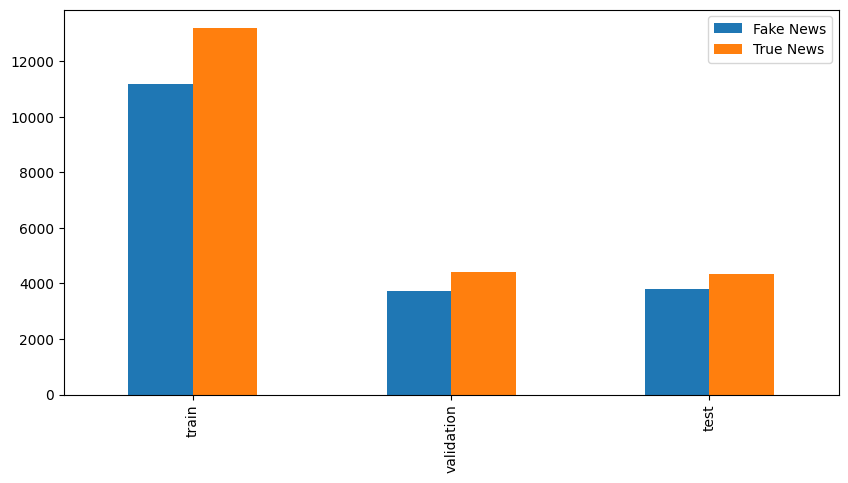

In [33]:
count_df = pd.DataFrame.from_dict(count_dict,orient = 'index')
count_df.rename(columns = {0:'Fake News',1:'True News'},inplace = True)
count_df.plot.bar(figsize = (10,5));

In [34]:
len_count_dict = dict()
for i in data:
    true_news = []
    fake_news = []
    for j in data[i]:
        if j['label'] == 0:
            fake_news.append(len(j['text']))
        else:
            true_news.append(len(j['text']))
    len_count_dict[i] = (np.mean(fake_news),np.mean(true_news))

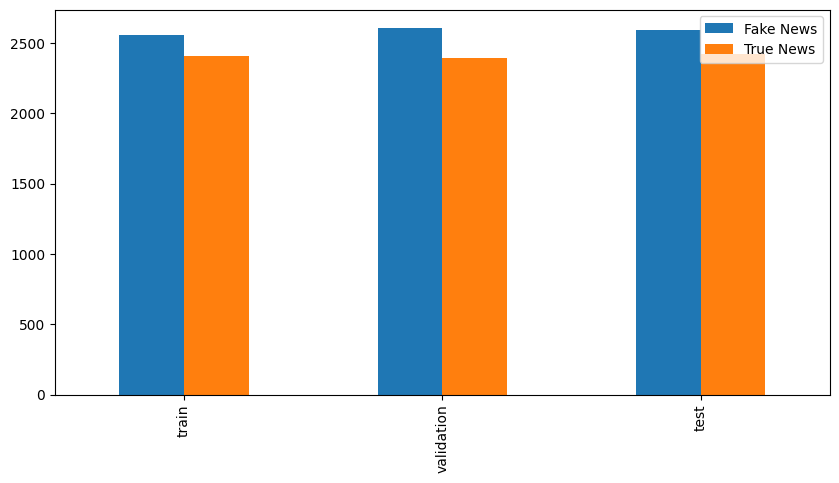

In [35]:
len_count_df = pd.DataFrame.from_dict(len_count_dict,orient = 'index')
len_count_df.rename(columns = {0:'Fake News',1:'True News'},inplace = True)
len_count_df.plot.bar(figsize = (10,5));

In [36]:
# tokenizer.get_vocab()

#### Inspecting over-represented tokens in our corpus (BERTopic)

In [37]:
topic_model_true = BERTopic()
topic_model_fake = BERTopic()

In [ ]:
train = pd.DataFrame(data['train'])

In [ ]:
Fake_news = train[train['label'] == 0]
True_news = train[train['label'] == 1]

In [ ]:
topics_fake, probs_fake = topic_model_fake.fit_transform(Fake_news['text'])

In [ ]:
topics_true, probs_true = topic_model_true.fit_transform(True_news['text'])

In [ ]:
results_bertopic_true = topic_model_true.get_document_info(True_news['text'])

In [ ]:
topic_model_true.get_topic_freq(0)

In [ ]:
topic_model_true.get_topic_info(0)['Representation'][0]

In [ ]:
results_bertopic_fake = topic_model_fake.get_document_info(Fake_news['text'])

In [ ]:
topics_list_true = list(results_bertopic_true[results_bertopic_true['Representative_document'] == True]['Representation'])
topics_list_fake = list(results_bertopic_fake[results_bertopic_fake['Representative_document'] == True]['Representation'])

In [ ]:
topics_list_true = [word.strip() for sublist in topics_list_true for word in sublist]
topics_list_fake = [word.strip() for sublist in topics_list_fake for word in sublist]

In [ ]:
ratio = dict()
for i in Counter(topics_list_fake):
    if i in Counter(topics_list_true):
        ratio[i] = Counter(topics_list_fake)[i]/Counter(topics_list_true)[i]

In [ ]:
sorted_dict = dict(sorted(ratio.items(), key=lambda item: item[1],reverse= True))

In [ ]:
pd.DataFrame.from_dict(sorted_dict,orient = 'index',columns = ['ratio'])[:20].plot.barh();

#### Inspecting over-represented tokens in our corpus (NLTK)

#### Inspecting the model and the head

In [38]:
inputs = tokenizer.encode(data['test'][9]['text'], return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

In [39]:
# head_view(attention, tokens)

In [40]:
# model_view(attention, tokens)

#### Inspecting the model's attention

In [41]:
pipe = pipeline('text-classification',model=model_name, top_k=None)

In [42]:
explainer = shap.Explainer(pipe)

In [43]:
# 0 - Fake | 1 - True

In [44]:
# labeled as True (1) but actually Fake (0)
shap_values = explainer([data['test'][59]['text']])

  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
shap.plots.text(shap_values)